<a href="https://colab.research.google.com/github/linjiw/linjiw.github.io/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

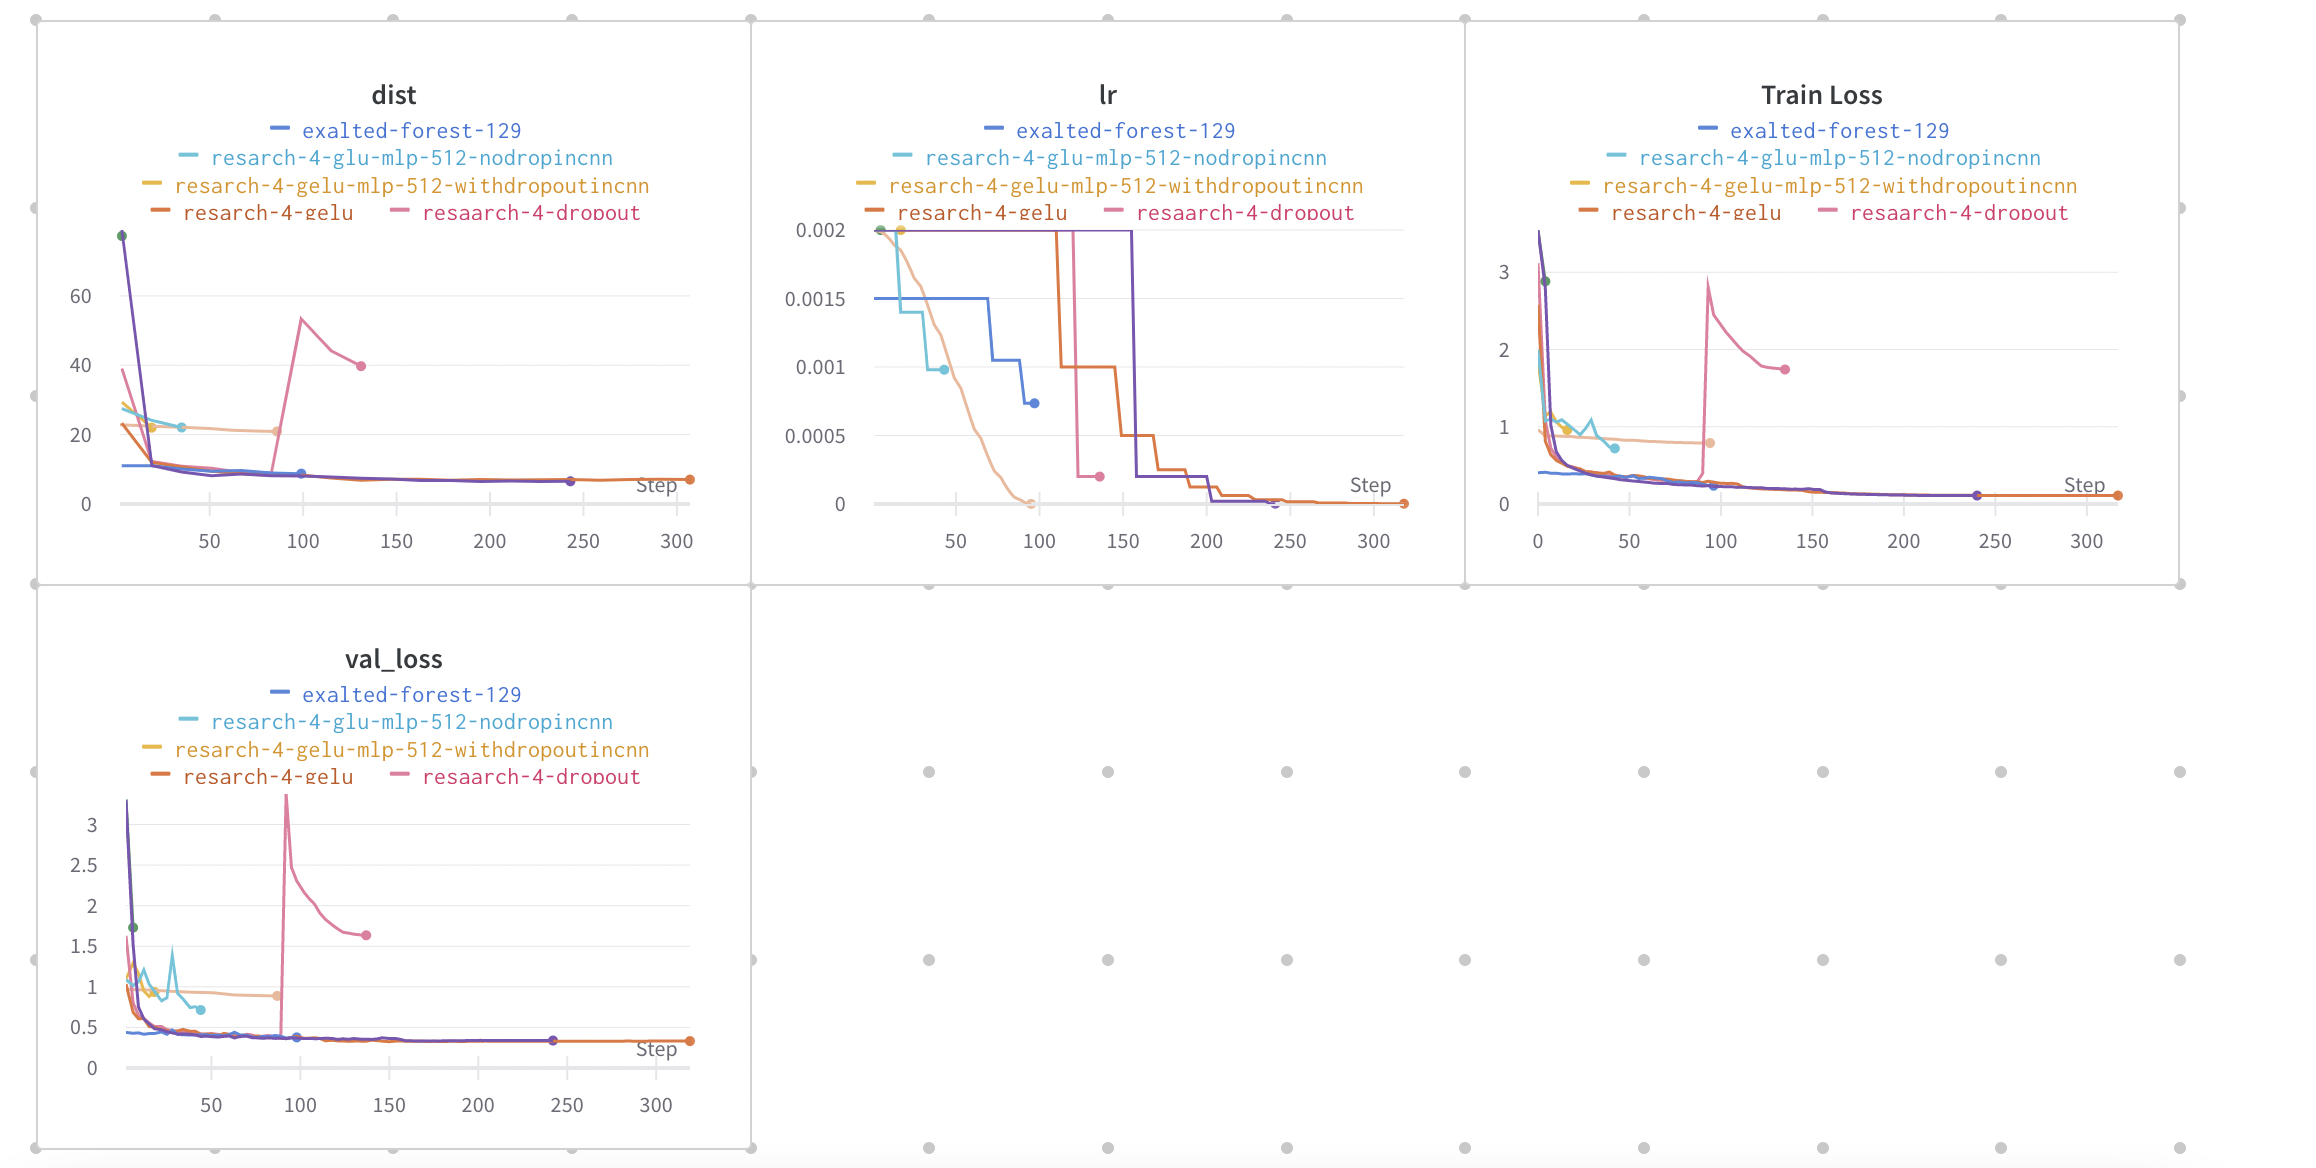

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"username","key":"key"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json
! kaggle competitions download -c 11-785-s22-hw3p2
! unzip 11-785-s22-hw3p2.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install wandb
!wandb login
# your key

In [ ]:
!pip install python-Levenshtein
!git clone --recursive https://github.com/parlance/ctcdecode.git
!pip install wget
%cd ctcdecode
!pip install .
%cd ..

!pip install torchsummaryX # We also install a summary package to check our model's forward before training

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from os.path import join
from sklearn.metrics import accuracy_score
import gc
import zipfile
import pandas as pd
from tqdm import tqdm
import os
import datetime
import phonemes
# imports for decoding and distance calculation
import ctcdecode
import Levenshtein
from ctcdecode import CTCBeamDecoder
import csv
import time
import warnings
from datetime import datetime
# from tqdm import tqdm_notebook as tqdm
import kaggle
import wandb
import torchaudio
wandb.init(project="HW3", entity="linjiw")
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)
# !jupyter nbextension enable --py widgetsnbextension



wandb: Currently logged in as: linjiw (use `wandb login --relogin` to force relogin)


Device:  cuda


In [ ]:
PHONEME_MAP = [
    " ",
    ".", #SIL
    "a", #AA
    "A", #AE
    "h", #AH
    "o", #AO
    "w", #AW
    "y", #AY
    "b", #B
    "c", #CH
    "d", #D
    "D", #DH
    "e", #EH
    "r", #ER
    "E", #EY
    "f", #F
    "g", #G
    "H", #H
    "i", #IH 
    "I", #IY
    "j", #JH
    "k", #K
    "l", #L
    "m", #M
    "n", #N
    "N", #NG
    "O", #OW
    "Y", #OY
    "p", #P 
    "R", #R
    "s", #S
    "S", #SH
    "t", #T
    "T", #TH
    "u", #UH
    "U", #UW
    "v", #V
    "W", #W
    "?", #Y
    "z", #Z
    "Z" #ZH
]
phe_dict = {}
tensor_dict = {}
PHONEMES = phonemes.PHONEMES
for idx, i in enumerate(PHONEMES):
    phe_dict[i] = PHONEME_MAP[idx]
    tensor_dict[PHONEME_MAP[idx]] = idx

def maplst(lst):
    res =[]
    for i in lst:
        res.append(phe_dict[i])
    res = np.array(res)
    # res = res.astype(np.float)
    return np.array(res)
def maptotensor(lst):
    res =[]
    for i in lst:
        res.append(tensor_dict[i])
    res = np.array(res)
    # res = res.astype(np.float)
    return np.array(res)

# %%
lst = ['B', 'IH', 'K', 'SH', 'AA']
res = maplst(lst)
tsr = maptotensor(res)
print(res)
print(tsr)

# %%


# %%
# This cell is where your actual TODOs start
# You will need to implement the Dataset class by your own. You may also implement it similar to HW1P2 (dont require context)
# The steps for implementation given below are how we have implemented it.
# However, you are welcomed to do it your own way if it is more comfortable or efficient. 


# freqmask = 
# timemask = torchaudio.transforms.TimeMasking(time_mask_param=2)
freqmask =  torchaudio.transforms.FrequencyMasking(freq_mask_param=13)
        # print(X.shape)
        
# X = timemask(X)
#          = freqmask(X
transform = nn.Sequential(freqmask)

# transform = nn.Sequential(timemask)

class LibriSamples(torch.utils.data.Dataset):

    def __init__(self, data_path, partition= "train"): # You can use partition to specify train or dev
        

        self.partition =  partition
        self.X_dir = os.path.join(data_path,partition,"mfcc/")# TODO: get mfcc directory path
        self.Y_dir = os.path.join(data_path,partition,"transcript/")# TODO: get transcript path

        self.X_files = os.listdir(self.X_dir)# TODO: list files in the mfcc directory
        self.Y_files = os.listdir(self.Y_dir)# TODO: list files in the transcript directory

        # TODO: store PHONEMES from phonemes.py inside the class. phonemes.py will be downloaded from kaggle.
        # You may wish to store PHONEMES as a class attribute or a global variable as well.
        self.PHONEMES = phonemes.PHONEMES

        assert(len(self.X_files) == len(self.Y_files))

        pass

    def __len__(self):
        return len(self.X_files)

    def __getitem__(self, ind):
        X_path = self.X_dir + self.X_files[ind]
        Y_path = self.Y_dir + self.Y_files[ind]
        X = np.load(X_path)
        X = torch.from_numpy(X)# TODO: Load the mfcc npy file at the specified index ind in the directory
        # Y = maplst(np.load(Y_path)[1:-1])# TODO: Load the corresponding transcripts
    #    )
        if self.partition == "train":
            X= transform(X)
        Y = np.load(Y_path)[1:-1]
        # print(Y)
        # print(Y.shape)
        # Y2 = PHONEMES.index(i) for i in np.load(Y_path)[1:-1]
        # print(f"Y {Y}")
        # print(f"Y2 {Y2}")
        # Remember, the transcripts are a sequence of phonemes. Eg. np.array(['<sos>', 'B', 'IH', 'K', 'SH', 'AA', '<eos>'])
        # You need to convert these into a sequence of Long tensors
        # Tip: You may need to use self.PHONEMES
        # Remember, PHONEMES or PHONEME_MAP do not have '<sos>' or '<eos>' but the transcripts have them. 
        # You need to remove '<sos>' and '<eos>' from the trancripts. 
        # Inefficient way is to use a for loop for this. Efficient way is to think that '<sos>' occurs at the start and '<eos>' occurs at the end.
        Yy = torch.LongTensor([PHONEMES.index(i) for i in Y])
        # Yy = torch.Tensor(maptotensor(Y)).type(torch.LongTensor)# TODO: Convert sequence of  phonemes into sequence of Long tensors
        # print(f"X {X.shape}")
        # print(f"Y {Y.shape}")
        return X, Yy
    
    def collate_fn(self,batch):

        batch_x = [x for x,y in batch]
        batch_y = [y for x,y in batch]

        # print(batch_x[0].shape)
        # batch_x = transform(batch_x)
        new_lst = []
        for idx, i in enumerate(batch_x):
            new_lst.append(batch_x[idx])
        batch_x_pad = pad_sequence(new_lst)
        # batch_x_pad = pad_sequence([i for i in batch_x], batch_first=False)# TODO: pad the sequence with pad_sequence (already imported)
        lengths_x = [len(i) for i in batch_x]# TODO: Get original lengths of the sequence before padding
        lengths_x_pad = [len(i) for i in batch_x_pad]

        
        # print(f"batch_x {batch_x}")
        

        # print(f"test_pad.len {test_pad.shape}")
        # print(f"batch_x.len {len(batch_x)}")
        # print(f"lengths_x {lengths_x}")
        # print(f"lengths_x_pad {lengths_x_pad}")

        new_lst = []
        for idx, i in enumerate(batch_y):
            new_lst.append(batch_y[idx])
        batch_y_pad = pad_sequence(new_lst)

        # batch_y_pad = pad_sequence(batch_y) # TODO: pad the sequence with pad_sequence (already imported)
        lengths_y = [len(i) for i in batch_y] # TODO: Get original lengths of the sequence before padding

        return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)
from torch.utils.data.dataset import Subset

# You can either try to combine test data in the previous class or write a new Dataset class for test data
class LibriSamplesTest(torch.utils.data.Dataset):

    def __init__(self, data_path, test_order): # test_order is the csv similar to what you used in hw1
        self.data_path = data_path
        test_csv_pth = os.path.join(data_path,'test',test_order)
        subset = list(pd.read_csv(test_csv_pth).file)
        # subset = self.parse_csv(test_csv_pth)
        test_order_list = subset# TODO: open test_order.csv as a list
        self.X_names = [i for i in subset]# TODO: Load the npy files from test_order.csv and append into a list
        # You can load the files here or save the paths here and load inside __getitem__ like the previous class
    @staticmethod
    def parse_csv(filepath):
        subset = []
        with open(filepath) as f:
            f_csv = csv.reader(f)
            for row in f_csv:
                subset.append(row[0])
        return subset[0:]
    def __len__(self):
        return len(self.X_names)
    
    def __getitem__(self, ind):
        # TODOs: Need to return only X because this is the test dataset
        X_path = os.path.join(self.data_path,'test','mfcc',self.X_names[ind])
        X = torch.Tensor(np.load(X_path))
        return X
    
    def collate_fn(self, batch):
        batch_x = [x for x in batch]
        new_lst = []
        for idx, i in enumerate(batch_x):
            new_lst.append(batch_x[idx])
        batch_x_pad = pad_sequence(new_lst)
        # batch_x_pad = pad_sequence([i for i in batch_x], batch_first=False)# TODO: pad the sequence with pad_sequence (already imported)
        lengths_x = [len(i) for i in batch_x]# TODO: Get original lengths of the sequence before padding
        # lengths_x_pad = [len(i) for i in batch_x_pad]
        # batch_x = [x for x in batch]
        # batch_x_pad = pad_sequence(batch_x)# TODO: pad the sequence with pad_sequence (already imported)
        # lengths_x = [len(i) for i in batch_x]# TODO: Get original lengths of the sequence before padding

        return batch_x_pad, torch.tensor(lengths_x)

['b' 'i' 'k' 'S' 'a']
[ 8 18 21 31  2]


#ResBlock

Resblock is one of my experiment, and it can reach to 6.3 using 4 resblock and 4 lstm later with GELU.

The resblock is used to prevent gradient vanishing using skip connection.

In [ ]:

class ResBlock(nn.Module):

    """
    Iniialize a residual block with two convolutions followed by batchnorm layers
    """
    def __init__(self,channel=256):
        super().__init__()

        # self.conv1 = nn.Conv1d(256,256,kernel_size = 3,stride= 1,padding=1)
        # self.conv2 = nn.Conv1d(256,256,kernel_size = 3,stride= 1,padding=1)
        # # self.layernorm1 = nn.LayerNorm(())
        # self.batchnorm1 = nn.BatchNorm1d(256)
        # self.batchnorm2 = nn.BatchNorm1d(256)
        self.oneblock = nn.Sequential(nn.Conv1d(channel,channel,kernel_size = 1,stride= 1,padding=0),nn.GELU(),nn.BatchNorm1d(channel),nn.Conv1d(channel,channel,kernel_size = 1,stride= 1,padding=0),nn.GELU(),nn.BatchNorm1d(channel))

    def convblock(self, x):
        # x = F.gelu(self.batchnorm1(self.conv1(x)))
        # x = F.gelu(self.batchnorm2(self.conv2(x)))
        x = self.oneblock(x)
        return x
   
    """
    Combine output with the original input
    """
    def forward(self, x): return x + self.convblock(x) # skip connection


class DepBlock(nn.Module):

    """
    Iniialize a residual block with two convolutions followed by batchnorm layers
    """
    def __init__(self,channel=256):
        super().__init__()

        # self.conv1 = nn.Conv1d(256,256,kernel_size = 3,stride= 1,padding=1)
        # self.conv2 = nn.Conv1d(256,256,kernel_size = 3,stride= 1,padding=1)
        # # self.layernorm1 = nn.LayerNorm(())
        # self.batchnorm1 = nn.BatchNorm1d(256)
        # self.batchnorm2 = nn.BatchNorm1d(256)
        expand_ratio = 4
        self.oneblock = nn.Sequential(nn.Conv1d(channel,expand_ratio*channel,kernel_size = 3,stride= 1,padding=1,groups=channel),nn.GELU(),nn.BatchNorm1d(expand_ratio*channel),
                                      nn.Conv1d(expand_ratio*channel,channel,kernel_size = 1,stride= 1,padding=0),nn.GELU(),nn.BatchNorm1d(channel))

    def convblock(self, x):
        # x = F.gelu(self.batchnorm1(self.conv1(x)))
        # x = F.gelu(self.batchnorm2(self.conv2(x)))
        x = self.oneblock(x)
        return x
   
    """
    Combine output with the original input
    """
    def forward(self, x): return x + self.convblock(x) # skip connection

class Network_v1(nn.Module):

    def __init__(self): # You can add any extra arguments as you wish

        super(Network_v1, self).__init__()

        # Embedding layer converts the raw input into features which may (or may not) help the LSTM to learn better 
        # For the very low cut-off you dont require an embedding layer. You can pass the input directly to the  LSTM
        # self.embedding = 
        # self.cnn = nn.Sequential(nn.Conv1d(13,128,kernel_size = 1,stride= 2),nn.BatchNorm1d(128),nn.Conv1d(128,256,kernel_size = 1,stride= 1),nn.BatchNorm1d(256))
        channel = 256
        self.layernorm0 = nn.LayerNorm(13)
        self.cnn1 = nn.Sequential(nn.Conv1d(13,channel,kernel_size = 3,stride= 1,padding=1),nn.BatchNorm1d(channel))
        self.res = nn.Sequential(*[DepBlock(channel) for i in range(2)])
        
        # self.mlp = nn.Linear(channel,256)
        lstm_nn = 512
        self.lstm = nn.LSTM(input_size=256,hidden_size= lstm_nn,bidirectional =True, num_layers= 4,dropout=0.25)# TODO: # Create a single layer, uni-directional LSTM with hidden_size = 256
        # Use nn.LSTM() Make sure that you give in the proper arguments as given in https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # self.layernorm = nn.LayerNorm(512)
        self.classification = nn.Sequential(nn.Linear(lstm_nn*2,4096),nn.GELU(),nn.Dropout(p=0.3),nn.Linear(4096,41))# TODO: Create a single classification layer using nn.Linear()

    def forward(self, x, lx): # TODO: You need to pass atleast 1 more parameter apart from self and x

        # x is returned from the dataloader. So it is assumed to be padded with the help of the collate_fn
        # print(x.shape)
        # x = self.layernorm0(x)
        x = self.cnn1(x.permute(1,2,0))
        x = self.res(x)
        x = x.permute(2,0,1)

        # x = self.mlp(x)
        # print(x.shape)
        
        
        packed_input = pack_padded_sequence(x,lx,enforce_sorted=False)# TODO: Pack the input with pack_padded_sequence. Look at the parameters it requires

        out1, (out2, out3) = self.lstm(packed_input)# TODO: Pass packed input to self.lstm
        # As you may see from the LSTM docs, LSTM returns 3 vectors. Which one do you need to pass to the next function?
        out, lengths  = pad_packed_sequence(out1)# TODO: Need to 'unpack' the LSTM output using pad_packed_sequence
        
        # out = out.permute(1,0,2)
        # print(out.shape)
        # out = self.layernorm(out)

        out = self.classification(out)# TODO: Pass unpacked LSTM output to the classification layer
        # out = # Optional: Do log softmax on the output. Which dimension?
        # print(out[0,0,:])
        out = torch.nn.functional.log_softmax(out,dim=2)
        # print(out[0,0,:])
        # print(sum(out[0,0,:]))
        return out, lengths # TODO: Need to return 2 variables

#Linjinn
Here is my experiment with my own network, it comes with the intuition from mobilenet and convnext of the depthwise convolution and the skip normal convolution. And since it has some downsample, so I changed the forward part to clamp the lx length.

In [ ]:
class linjinn(nn.Module):
    def __init__(self,):
        super().__init__()
        self.cnn = nn.Sequential(nn.Conv1d(13,64,kernel_size = 1,stride= 1),nn.BatchNorm1d(64),nn.GELU(),nn.Conv1d(64,64,kernel_size = 1,stride= 1,padding=0,groups=64),
                            # nn.GELU(),
                            nn.BatchNorm1d(64),
                            nn.Conv1d(64,64*4,kernel_size = 1,stride= 1),
                            nn.GELU(),
                            # nn.BatchNorm1d(64*4),
                            nn.Conv1d(64*4,64*4,kernel_size = 1,stride= 1,padding=0,groups=64*4),
                            # nn.GELU(),
                            nn.BatchNorm1d(64*4),
                            nn.Conv1d(64*4,128,kernel_size = 1,stride= 1),
                            nn.GELU(),
                            # nn.BatchNorm1d(128),
                            nn.MaxPool1d(kernel_size=3,stride=2, padding=1),
                            nn.Conv1d(128,128,kernel_size = 3,stride= 1,padding=1,groups=128),
                            nn.BatchNorm1d(128),
                            nn.Conv1d(128,256,kernel_size = 1,stride= 1),
                            nn.GELU(),
                            )
        self.lstm = nn.LSTM(input_size=256,hidden_size= 512,bidirectional =True, num_layers= 5,dropout=0.2)
        self.classification = nn.Sequential(nn.Linear(512*2,4096),nn.GELU(),nn.Dropout(p=0.2),nn.Linear(4096,41))
    def forward(self, x, lx):
        # print(x.shape)
        # print()
        max_lx = x.shape[0]//2
        lx = torch.clamp(lx,max = max_lx)
        x = self.cnn(x.permute(1,2,0))
        # x = self.res(x)
        # x = self.mapback(x)
        x = x.permute(2,0,1)

        # x = self.mlp(x)
        # print(x.shape)
        
        
        packed_input = pack_padded_sequence(x,lx,enforce_sorted=False)# TODO: Pack the input with pack_padded_sequence. Look at the parameters it requires

        out1, (out2, out3) = self.lstm(packed_input)# TODO: Pass packed input to self.lstm
        # As you may see from the LSTM docs, LSTM returns 3 vectors. Which one do you need to pass to the next function?
        out, lengths  = pad_packed_sequence(out1)# TODO: Need to 'unpack' the LSTM output using pad_packed_sequence
        
        # out = out.permute(1,0,2)
        # print(out.shape)
        # out = self.layernorm(out)

        out = self.classification(out)# TODO: Pass unpacked LSTM output to the classification layer
        # out = # Optional: Do log softmax on the output. Which dimension?
        # print(out[0,0,:])
        out = torch.nn.functional.log_softmax(out,dim=2)
        # print(out[0,0,:])
        # print(sum(out[0,0,:]))
        return out, lengths # TODO: Need to return 2 variables

In [ ]:
model = linjinn()
lr = 0.0020
# lr = 5e-4
batch_size = 48
epochs = 100
num_classes = 41
wandb.config = {
  "learning_rate": lr,
  "epochs": epochs,
  "batch_size": batch_size
}

root = 'hw3p2_student_data/hw3p2_student_data' # TODO: Where your hw3p2_student_data folder is

train_data = LibriSamples(root, 'train')
val_data = LibriSamples(root, 'dev')
test_data = LibriSamplesTest(root, 'test_order.csv')


train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=False,collate_fn=train_data.collate_fn, num_workers=8)# TODO: Define the train loader. Remember to pass in a parameter (function) for the collate_fn argument 
val_loader = DataLoader(val_data,batch_size=batch_size,shuffle=False,collate_fn=val_data.collate_fn, num_workers=8)# TODO: Define the val loader. Remember to pass in a parameter (function) for the collate_fn argument 
test_loader = DataLoader(test_data,batch_size=batch_size,shuffle=False,collate_fn=test_data.collate_fn, num_workers=8)# TODO: Define the test loader. Remember to pass in a parameter (function) for the collate_fn argument 




print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

criterion = nn.CTCLoss()# TODO: What loss do you need for sequence to sequence models? 
# Do you need to transpose or permute the model output to find out the loss? Read its documentation
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-3)# TODO: Adam works well with LSTM (use lr = 2e-3)
# optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=5e-4)
# optimizer = torch.optim.SGD(model.parameters(),lr=0.02,momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=(len(train_loader) * epochs))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=3,factor=0.7)
scaler = torch.cuda.amp.GradScaler()

decoder = ctcdecode.CTCBeamDecoder(labels = PHONEME_MAP,
    model_path=None,
    alpha=0,
    beta=0,
    cutoff_top_n=40,
    cutoff_prob=1.0,
    beam_width=1,
    num_processes=8,
    blank_id=0,
    log_probs_input=True)# TODO: Intialize the CTC beam decoder
# Check out https://github.com/parlance/ctcdecode for the details on how to implement decoding
# Do you need to give log_probs_input = True or False?
def pred(h,lh,decoder,PHONEME_MAP):
    h = h.permute(1, 0, 2)
    beam_results, _, _, out_lens = decoder.decode(h,seq_lens=lh)
    h_string_lst = []
    batch_s = h.shape[0]
    for i in range(batch_s): 

        h_sliced = beam_results[i][0][:out_lens[i,0]]
        h_string = "".join([PHONEME_MAP[j] for j in h_sliced])
        h_string_lst.append(h_string)
    return h_string_lst
def calculate_levenshtein(h, y, lh, ly, decoder, PHONEME_MAP):

    # h - ouput from the model. Probability distributions at each time step 
    # y - target output sequence - sequence of Long tensors
    # lh, ly - Lengths of output and target
    # decoder - decoder object which was initialized in the previous cell
    # PHONEME_MAP - maps output to a character to find the Levenshtein distance

    h = h.permute(1, 0, 2)# TODO: You may need to transpose or permute h based on how you passed it to the criterion
    # Print out the shapes often to debug
    t1 =time.time()
    beam_results, _, _, out_lens = decoder.decode(h,seq_lens=lh)
    t2 = time.time()
    # print(f"time cost {t2-t1}")
    # TODO: call the decoder's decode method and get beam_results and out_len (Read the docs about the decode method's outputs)
    # Input to the decode method will be h and its lengths lh 
    # You need to pass lh for the 'seq_lens' parameter. This is not explicitly mentioned in the git repo of ctcdecode.

    batch_s = h.shape[0]# TODO
    # print(f"batch_szie {batch_size}")

    dist = 0

    # dist = 0
    # h = np.zeros((100,))  
    # y = y.cpu().detach().numpy().astype(int)
    for i in range(batch_s): # Loop through each element in the batch

    # for j in range(100)
        h_sliced = beam_results[i][0][:out_lens[i,0]]
    # print(h_sliced.shape)
        # TODO: Get the output as a sequence of numbers from beam_results
        # Remember that h is padded to the max sequence length and lh contains lengths of individual sequences
        # Same goes for beam_results and out_lens
        # You do not require the padded portion of beam_results - you need to slice it with out_lens 
        # If it is confusing, print out the shapes of all the variables and try to understand

        h_string = "".join([PHONEME_MAP[j] for j in h_sliced])# TODO: MAP the sequence of numbers to its corresponding characters with PHONEME_MAP and merge everything as a single string
        # print(f"ly.shape {ly.shape}")
        # print(f"y.shape {y.shape}")
        y_sliced = y[i][:ly[i]]
        y_string = "".join([PHONEME_MAP[j] for j in y_sliced])# TODO: MAP the sequence of numbers to its corresponding characters with PHONEME_MAP and merge everything as a single string
        # print(f"h_string {h_string} h_string.len {len(h_string)}")
        # print(f"y_string {y_string} y_string.len {len(y_string)}")
        per_dist = Levenshtein.distance(h_string, y_string)
        # print(f"{i} {per_dist} ")
        dist += per_dist

    dist/=batch_s
    return dist

Batch size:  48
Train dataset samples = 28539, batches = 595
Val dataset samples = 2703, batches = 57
Test dataset samples = 2620, batches = 55


In [ ]:
model.to(device)

# model.load_state_dict(torch.load("/content/drive/MyDrive/11785/hw3p2/HW3 Starter/model/0.4600294232368469_10_05_04_2022_22_12_13model.pth"))
for epoch in range(epochs):
    
    # num_correct = 0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc=f'Train epoch: {epoch+1}') 
    total_loss = 0
    model.train()
    desc = "start"
    # tq = tqdm(train_loader, desc=desc,dynamic_ncols=True)
    # with tqdm(train_loader, desc=desc,dynamic_ncols=True) as tq:
    for i, (x, y, lx, ly) in enumerate(train_loader):
        
        optimizer.zero_grad()
        x = x.cuda()
        y = y.cuda()
        # lx = (lx/2).type(torch.LongTensor)
        with torch.cuda.amp.autocast():
            out, out_len = model(x,lx)
            loss = criterion(out,y.permute(1,0), out_len, ly)
        total_loss += loss
        # desc = "loss = {:.04f}".format(float(total_loss / (i + 1)))
        # desc += "lr = {:.04f}".format(float(optimizer.param_groups[0]['lr']))
        batch_bar.set_postfix(
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])))
        # loss.backward()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        # optimizer.step()
        # scheduler.step()
        # tq.update()
        scaler.update()
        batch_bar.update()
        torch.cuda.empty_cache() 
    batch_bar.close()
    
    tqdm.write("Epoch {}/{}: Train Loss {:.04f}, Learning Rate {:.04f}".format(
        epoch + 1,
        epochs,
        float(total_loss / len(train_loader)),
        float(optimizer.param_groups[0]['lr'])))
    wandb.log({"Train Loss": float(total_loss / len(train_loader))})
    wandb.log({"lr" : float(optimizer.param_groups[0]['lr'])})

    # if epoch%5==0:
    model.eval()
    
    t_val_loss = 0
    for i, data in enumerate(val_loader, 0):
        spectrograms, labels, input_lengths, label_lengths = data
        # print(f"label_lengths {label_lengths}")
        spectrograms, labels =spectrograms.to(device), labels
        # input_lengths = (input_lengths/2).type(torch.LongTensor)
        with torch.no_grad():
            out,out_lengths = model(spectrograms,input_lengths)
        t_val_loss += criterion(out,labels.permute(1,0), out_lengths, label_lengths)
        
    val_loss = t_val_loss/len(val_loader)
    scheduler.step(val_loss)
    tqdm.write("Epoch {}/{}: val loss {:.04f}".format(
            epoch + 1,
            epochs,
            float(val_loss),
            ))
    
    wandb.log({"val_loss" : float(val_loss)})
    now_name = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    torch.save(model.state_dict(), f"/content/drive/MyDrive/11785/hw3p2/HW3 Starter/model/{float(val_loss)}_{epoch}_{now_name}model.pth")
    if epoch%5==0:
        t_dist = 0
        for i, data in enumerate(val_loader, 0):
            spectrograms, labels, input_lengths, label_lengths = data
            # print(f"label_lengths {label_lengths}")
            spectrograms, labels =spectrograms.to(device), labels
            # input_lengths = (input_lengths/2).type(torch.LongTensor)
            with torch.no_grad():
                out,out_lengths = model(spectrograms,input_lengths)
            t_dist = calculate_levenshtein(out, labels.permute(1,0), out_lengths, label_lengths, decoder, PHONEME_MAP)
            break
        # dist = t_dist/len(val_loader)
        wandb.log({"dist" : float(t_dist)})
        tqdm.write("distance {:.04f}".format(
            float(t_dist),
            ))
    #     true_y_list = []
    #     pred_y_list = []
    #     with torch.no_grad():
    #         for i in range(1):
    #         # X = test_samples[i]

    #         # test_items = test_item(X, context=args['context'])
    #         # test_loader = torch.utils.data.DataLoader(test_items, batch_size=args['batch_size'], shuffle=False)

    #             for x, lx in test_loader:
    #             # data = data.float().to(device)
    #                 x = x.cuda()
    #                 # y = y.cuda()
    #                 out, out_len = model(x,lx)
    #                 pred_y = pred(out,out_len,decoder,PHONEME_MAP)
    #             # print(out.shape)
    #             # pred_y = torch.argmax(out, axis=2)
    #             # print(pred_y.shape)
    #                 pred_y_list.extend(pred_y)
    # # print(pred_y_list)
    # # now_name = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    #     f = open(f"bad.csv", "w")
    #     f.write("id,predictions\n")
    #     for idx, i  in enumerate(pred_y_list):
    #         f.write(f"{idx},{i}\n")
    #     f.close()
    #     kaggle.api.competition_submit('bad.csv','nice','11-785-s22-hw3p2')

Epoch 1/100: Train Loss 2.4969, Learning Rate 0.0020


Epoch 1/100: val loss 1.4145
distance 32.5208


Epoch 2/100: Train Loss 1.1998, Learning Rate 0.0020


Epoch 2/100: val loss 1.1354


Epoch 3/100: Train Loss 1.0155, Learning Rate 0.0020


Epoch 3/100: val loss 1.0584


Epoch 4/100: Train Loss 0.9473, Learning Rate 0.0020


Epoch 4/100: val loss 0.9980


Epoch 5/100: Train Loss 0.9075, Learning Rate 0.0020


Epoch 5/100: val loss 0.9718


Epoch 6/100: Train Loss 0.8829, Learning Rate 0.0020


Epoch 6/100: val loss 0.9283
distance 21.4792


Epoch 7/100: Train Loss 0.8633, Learning Rate 0.0020


Epoch 7/100: val loss 0.8861


Epoch 8/100: Train Loss 0.8468, Learning Rate 0.0020


Epoch 8/100: val loss 0.8870


Epoch 9/100: Train Loss 0.8311, Learning Rate 0.0020


Epoch 9/100: val loss 0.8745


Epoch 10/100: Train Loss 0.8199, Learning Rate 0.0020


Epoch 10/100: val loss 0.8465


Epoch 11/100: Train Loss 0.8099, Learning Rate 0.0020


Epoch 11/100: val loss 0.9080
distance 20.2292


Epoch 12/100: Train Loss 0.8006, Learning Rate 0.0020


Epoch 12/100: val loss 0.8344


Epoch 13/100: Train Loss 0.7945, Learning Rate 0.0020


Epoch 13/100: val loss 0.8507


Epoch 14/100: Train Loss 0.7877, Learning Rate 0.0020


Epoch 14/100: val loss 0.8834


Epoch 15/100: Train Loss 0.7824, Learning Rate 0.0020


Epoch 15/100: val loss 0.9205


Epoch 16/100: Train Loss 0.7788, Learning Rate 0.0020


Epoch 16/100: val loss 0.8328
distance 19.0000


Epoch 17/100: Train Loss 0.7746, Learning Rate 0.0020


Epoch 17/100: val loss 0.8065


Epoch 18/100: Train Loss 0.7709, Learning Rate 0.0020


Epoch 18/100: val loss 0.8450


Epoch 19/100: Train Loss 0.7674, Learning Rate 0.0020


Epoch 19/100: val loss 0.8112


Epoch 20/100: Train Loss 0.7629, Learning Rate 0.0020


Epoch 20/100: val loss 0.8261


Epoch 21/100: Train Loss 0.7606, Learning Rate 0.0020


Epoch 21/100: val loss 0.8281
distance 19.1667


Epoch 22/100: Train Loss 0.7232, Learning Rate 0.0014


Epoch 22/100: val loss 0.7590


Epoch 23/100: Train Loss 0.7211, Learning Rate 0.0014


Epoch 23/100: val loss 0.7294


Epoch 24/100: Train Loss 0.7175, Learning Rate 0.0014


Epoch 24/100: val loss 0.7581


Epoch 25/100: Train Loss 0.7153, Learning Rate 0.0014


Epoch 25/100: val loss 0.7357


Epoch 26/100: Train Loss 0.7127, Learning Rate 0.0014


Epoch 26/100: val loss 0.7318
distance 16.6458


Epoch 27/100: Train Loss 0.7093, Learning Rate 0.0014


Epoch 27/100: val loss 0.7318


Epoch 28/100: Train Loss 0.6793, Learning Rate 0.0010


Epoch 28/100: val loss 0.7094


Epoch 29/100: Train Loss 0.6766, Learning Rate 0.0010


Epoch 29/100: val loss 0.7100


Epoch 30/100: Train Loss 0.6753, Learning Rate 0.0010


Epoch 30/100: val loss 0.6953


Epoch 31/100: Train Loss 0.6724, Learning Rate 0.0010


Epoch 31/100: val loss 0.6940
distance 16.2083


Epoch 32/100: Train Loss 0.6716, Learning Rate 0.0010


Epoch 32/100: val loss 0.7154


Epoch 33/100: Train Loss 0.6677, Learning Rate 0.0010


Epoch 33/100: val loss 0.6933


Epoch 34/100: Train Loss 0.6676, Learning Rate 0.0010


Epoch 34/100: val loss 0.7122


Epoch 35/100: Train Loss 0.6667, Learning Rate 0.0010


Epoch 35/100: val loss 0.6916


Epoch 36/100: Train Loss 0.6649, Learning Rate 0.0010


Epoch 36/100: val loss 0.6870
distance 15.7292


Epoch 37/100: Train Loss 0.6616, Learning Rate 0.0010


Epoch 37/100: val loss 0.7248


Epoch 38/100: Train Loss 0.6616, Learning Rate 0.0010


Epoch 38/100: val loss 0.6800


Epoch 39/100: Train Loss 0.6597, Learning Rate 0.0010


Epoch 39/100: val loss 0.7128


Epoch 40/100: Train Loss 0.6590, Learning Rate 0.0010


Epoch 40/100: val loss 0.6913


Epoch 41/100: Train Loss 0.6581, Learning Rate 0.0010


Epoch 41/100: val loss 0.6949
distance 15.9375


Epoch 42/100: Train Loss 0.6581, Learning Rate 0.0010


Epoch 42/100: val loss 0.7040


Epoch 43/100: Train Loss 0.6315, Learning Rate 0.0007


Epoch 43/100: val loss 0.6658


Epoch 44/100: Train Loss 0.6312, Learning Rate 0.0007


Epoch 44/100: val loss 0.6539


Epoch 45/100: Train Loss 0.6302, Learning Rate 0.0007


Epoch 45/100: val loss 0.6509


Epoch 46/100: Train Loss 0.6291, Learning Rate 0.0007


Epoch 46/100: val loss 0.6497
distance 15.5625


Epoch 47/100: Train Loss 0.6278, Learning Rate 0.0007


Epoch 47/100: val loss 0.6508


Epoch 48/100: Train Loss 0.6258, Learning Rate 0.0007


Epoch 48/100: val loss 0.6531


Epoch 49/100: Train Loss 0.6245, Learning Rate 0.0007


Epoch 49/100: val loss 0.6599


Epoch 50/100: Train Loss 0.6235, Learning Rate 0.0007


Epoch 50/100: val loss 0.6512


Epoch 51/100: Train Loss 0.6030, Learning Rate 0.0005


Epoch 51/100: val loss 0.6190
distance 14.7708


Epoch 52/100: Train Loss 0.6005, Learning Rate 0.0005


Epoch 52/100: val loss 0.6237


Epoch 53/100: Train Loss 0.6013, Learning Rate 0.0005


Epoch 53/100: val loss 0.6327


Epoch 54/100: Train Loss 0.6000, Learning Rate 0.0005


Epoch 54/100: val loss 0.6327


Epoch 55/100: Train Loss 0.5994, Learning Rate 0.0005


Epoch 55/100: val loss 0.6213


Epoch 56/100: Train Loss 0.5805, Learning Rate 0.0003


Epoch 56/100: val loss 0.5866
distance 13.7083


Epoch 57/100: Train Loss 0.5797, Learning Rate 0.0003


Epoch 57/100: val loss 0.6041


Epoch 58/100: Train Loss 0.5797, Learning Rate 0.0003


Epoch 58/100: val loss 0.5937


Epoch 59/100: Train Loss 0.5781, Learning Rate 0.0003


Epoch 59/100: val loss 0.5960


Epoch 60/100: Train Loss 0.5783, Learning Rate 0.0003


Epoch 60/100: val loss 0.5912


Epoch 61/100: Train Loss 0.5630, Learning Rate 0.0002


Epoch 61/100: val loss 0.5812
distance 13.6042


Epoch 62/100: Train Loss 0.5629, Learning Rate 0.0002


Epoch 62/100: val loss 0.5814


Epoch 63/100: Train Loss 0.5616, Learning Rate 0.0002


Epoch 63/100: val loss 0.5760


Epoch 64/100: Train Loss 0.5612, Learning Rate 0.0002


Epoch 64/100: val loss 0.5823


Epoch 65/100: Train Loss 0.5611, Learning Rate 0.0002


Epoch 65/100: val loss 0.5771


Epoch 66/100: Train Loss 0.5587, Learning Rate 0.0002


Epoch 66/100: val loss 0.5764
distance 13.2083


Epoch 67/100: Train Loss 0.5585, Learning Rate 0.0002


Epoch 67/100: val loss 0.5811


Epoch 68/100: Train Loss 0.5482, Learning Rate 0.0002


Epoch 68/100: val loss 0.5657


Epoch 69/100: Train Loss 0.5467, Learning Rate 0.0002


Epoch 69/100: val loss 0.5634


Epoch 70/100: Train Loss 0.5458, Learning Rate 0.0002


Epoch 70/100: val loss 0.5665


Epoch 71/100: Train Loss 0.5466, Learning Rate 0.0002


Epoch 71/100: val loss 0.5700
distance 12.9375


Epoch 72/100: Train Loss 0.5451, Learning Rate 0.0002


Epoch 72/100: val loss 0.5674


Epoch 73/100: Train Loss 0.5451, Learning Rate 0.0002


Epoch 73/100: val loss 0.5664


Epoch 74/100: Train Loss 0.5357, Learning Rate 0.0001


Epoch 74/100: val loss 0.5576


Epoch 75/100: Train Loss 0.5361, Learning Rate 0.0001


Epoch 75/100: val loss 0.5524


Epoch 76/100: Train Loss 0.5360, Learning Rate 0.0001


Epoch 76/100: val loss 0.5536
distance 12.5000


Epoch 77/100: Train Loss 0.5349, Learning Rate 0.0001


Epoch 77/100: val loss 0.5560


Epoch 78/100: Train Loss 0.5351, Learning Rate 0.0001


Epoch 78/100: val loss 0.5557


Train epoch: 79:  97%|█████████▋| 580/595 [08:41<00:13,  1.11it/s, loss=0.5338, lr=0.0001]

In [ ]:
# kaggle.api.competition_submit('/home/linjiw/Downloads/hw3/tmp/bad.csv','nice','11-785-s22-hw3p2')